In [1]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mesh = 'cube'
step = 20

## rebuild structure from Giessen paper
## (Schäferling et al. PRX 2, 031010 (2012))
full_geo = structures.rect_wire(step, L=int(400/step), W=int(400/step), H=2)
full_geo = full_geo[np.logical_not(np.logical_and(np.logical_and(
                full_geo.T[0]>40,
                full_geo.T[0]<=120),
                full_geo.T[1]<=-40) )]
full_geo = full_geo[np.logical_not(np.logical_and(np.logical_and(
                full_geo.T[0]<=-40,
                full_geo.T[1]>-120),
                full_geo.T[1]<=-40) )]

full_geo = full_geo[np.logical_not(np.logical_and(np.logical_and(
                full_geo.T[0]<=-40,
                full_geo.T[0]>-120),
                full_geo.T[1]>40) )]
full_geo = full_geo[np.logical_not(np.logical_and(np.logical_and(
                full_geo.T[0]>40,
                full_geo.T[1]<=120),
                full_geo.T[1]>40) )]

full_geo.T[0] = full_geo.T[0]*-1

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 544/544 dipoles valid


c:\Users\jones\anaconda3\envs\CompEnv\Lib\site-packages\pyGDM2\visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


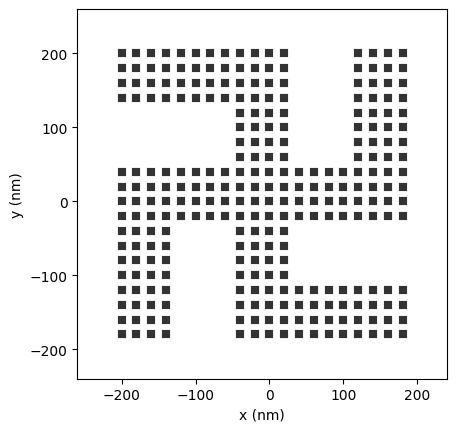

N_dipoles sim = 544


In [3]:
material = materials.gold()
struct = structures.struct(step, full_geo, material)

## --- Setup incident field: LCP and RCP plane wave
field_generator = fields.plane_wave
wavelengths = [2500]
kwargs = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[-np.pi/2, np.pi/2])    # LCP, RCP
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

## --- environment: vacuum
dyads = propagators.DyadsQuasistatic123(n1=1)


sim = core.simulation(struct, efield, dyads)

visu.structure(sim)
print ('N_dipoles sim =', len(sim.struct.geometry))

In [4]:
sim.scatter()


timing for wl=2500.00nm - setup: EE 6458.2ms, inv.: 281.4ms, repropa.: 3944.1ms (2 field configs), tot: 10683.6ms


1

In [5]:
fidx_LCP = 0      # LCP
fidx_RCP = 1      # RCP

## here the structure lies in positive z space
## --> adapt Z values to match Schäferling, where structure is centered at z=0
Z0_below = -50
Z0_above = 90
r_probe_above = tools.generate_NF_map(-300,300,51, -300,300,51, Z0=Z0_above)
r_probe_below = tools.generate_NF_map(-300,300,51, -300,300,51, Z0=Z0_below)

In [6]:
Es_above, Et, Bs, Bt = linear.nearfield(sim, fidx_RCP, r_probe=r_probe_above)
Es_below, Et, Bs, Bt = linear.nearfield(sim, fidx_RCP, r_probe=r_probe_below)

In [7]:
C_LCP_below = linear.optical_chirality(sim, fidx_LCP, r_probe_below, which_field='s')
C_RCP_below = linear.optical_chirality(sim, fidx_RCP, r_probe_below, which_field='s')
C_LCP_above = linear.optical_chirality(sim, fidx_LCP, r_probe_above, which_field='s')
C_RCP_above = linear.optical_chirality(sim, fidx_RCP, r_probe_above, which_field='s')

In [8]:
def confplot(im, sim, C_label=True):
    visu.structure_contour(sim, color='k', lw=1.5, show=0)
    visu.structure_contour(sim, color='w', lw=1.5, dashes=[2,2], show=0)
    if C_label:
        im.set_clim(-2.5, 2.5)
        plt.colorbar(im, label='C / C_LCP')
    plt.xlim(300,-300)   # invert x-axis like in Ref. [1]


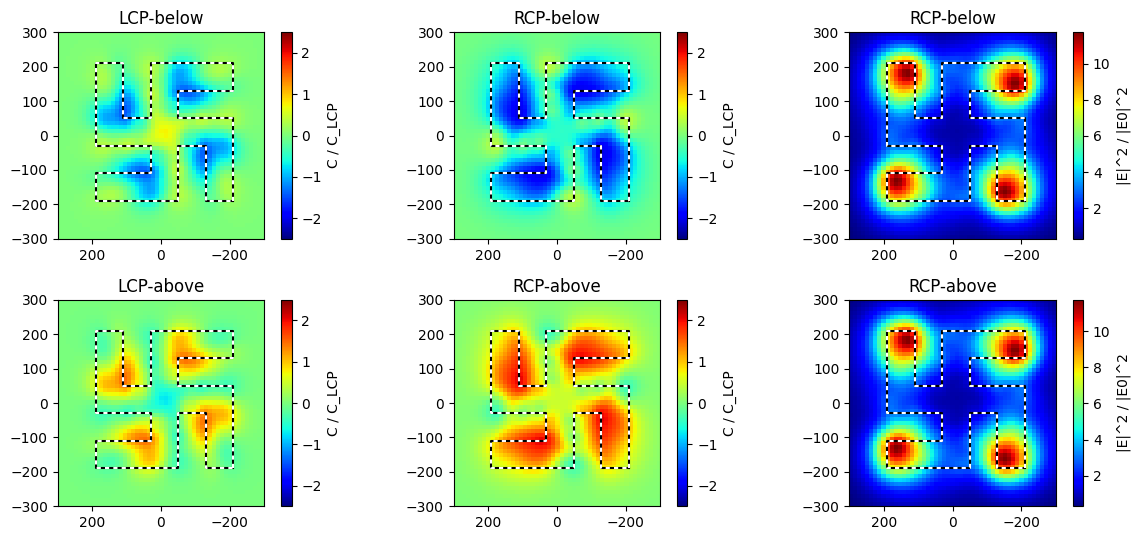

In [9]:
plt.figure(figsize=(12, 5.5))


## --- below gammadion
plt.subplot(2,3,1, aspect='equal')
plt.title("LCP-below")
im = visu.scalarfield(C_LCP_below, cmap='jet', show=0)
confplot(im, sim)

plt.subplot(2,3,2, aspect='equal')
plt.title("RCP-below")
im = visu.scalarfield(C_RCP_below, cmap='jet', show=0)
confplot(im, sim)

plt.subplot(2,3,3, aspect='equal')
plt.title("RCP-below")
im = visu.vectorfield_color(Es_above, cmap='jet',show=0)
plt.colorbar(im, label="|E|^2 / |E0|^2")
confplot(im, sim, C_label=False)


## --- above gammadion
plt.subplot(2,3,4, aspect='equal')
plt.title("LCP-above")
im = visu.scalarfield(C_LCP_above, cmap='jet', show=0)
confplot(im, sim)

plt.subplot(2,3,5, aspect='equal')
plt.title("RCP-above")
im = visu.scalarfield(C_RCP_above, cmap='jet', show=0)
confplot(im, sim)

plt.subplot(2,3,6, aspect='equal')
plt.title("RCP-above")
im = visu.vectorfield_color(Es_above, cmap='jet',show=0)
plt.colorbar(im, label="|E|^2 / |E0|^2")
confplot(im, sim, C_label=False)


plt.tight_layout()
plt.show()